## Step0. 필요 라이브러리 설치
아래 라이브러리 설치 후 런타임 재시작

In [ ]:
%%capture
!pip install super-gradients
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

## Step1. 필요 라이브러리 import & GPU 설정

In [4]:
import cv2
import torch
from IPython.display import clear_output
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import models


#-- GPU 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

cuda:0
True
Tesla T4


## Step2. 체크포인트 설정

In [5]:
from super_gradients.training import Trainer
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='Pokemon_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

## Step3. roboflow 데이터를 코랩으로 가져오기
roboflow에서 복사해뒀던 코드를 붙여넣기

In [6]:
# !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3NnsrtodD4CdBVrs1VJk")
project = rf.workspace("pokmon").project("pokemon-2atdu")
dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Pokemon-1 in yolov5pytorch:: 100%|██████████| 588/588 [00:00<00:00, 7651.80it/s]


## Step4. 디렉토리로 데이터셋 로드

In [7]:
dataset_params = {
    'data_dir':'/content/Pokemon-1',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['Bulbasaur','Charmander','Squirtle']
}

## Step5. 데이터 parmas를 데이터셋 parmas 인자로 삽입

In [8]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
        # 'show_all_warnings': True
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)


test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 12/12 [00:00<00:00, 3103.44it/s]


## Step6. 앞에서 정의한 데이터 세트 검사

In [9]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [10]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [11]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

## Step7. 증폭 기능이 적용된 훈련 데이터 시각화

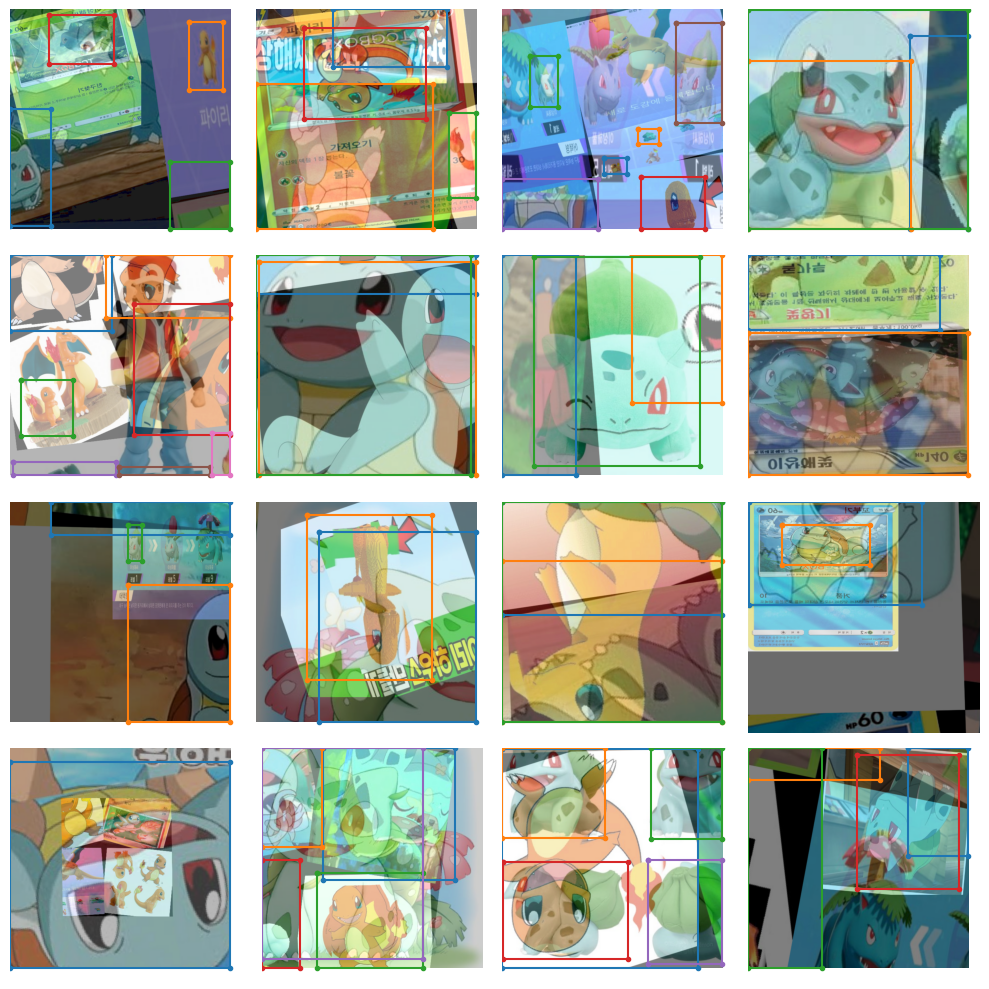

In [12]:
train_data.dataset.plot()

## Step8. 모델 인스턴스화

다음은 미세 조정을 위해 모델을 인스턴스화하는 방법이다 여기에 `num_classes` 인수를 추가해야 한다는 점에 유의해야 한다.

이 튜토리얼에서는 `yolo_nas_s`를 사용하지만, 슈퍼 그레이디언트에는 두 가지 다른 종류의 yolo_nas_m`과 `yolo_nas_l`를 사용할 수 있다.

In [13]:
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2023-12-26 11:42:27] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:18<00:00, 14.8MB/s]
[2023-12-26 11:42:46] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


## Step9. 모델 하이퍼 파라미터 설정
- `max_epochs` - 최대 훈련 에포크 수

- `loss` - 사용하려는 손실 함수
- `optimizer` - 사용하려는 손실 함수

- `train_metrics_list` - 트레이닝 중에 기록할 메트릭

- `valid_metrics_list` - 트레이닝 중에 기록할 메트릭

- `metric_to_watch` - 모델 체크포인트가 저장될 지표

다음과 같은 다양한 `옵티마이저` 중에서 선택할 수 있다: Adam, AdamW, SGD, Lion 또는 RMSProps. 이러한 옵티마이저의 잘못된 파라미터를 변경하려면 해당 파라미터를 `optimizer_params`에 전달한다.


In [14]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # 이 예제의 경우 15개의 에포크만 교육한다.
    "max_epochs": 20,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # 참고: num_classes는 여기에 정의되어야 한다.
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # 참고: num_classes는 여기에 정의되어야 한다.
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

## Step10. 모델 학습

In [15]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2023-12-26 11:42:57] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231226_114257_787184`
[2023-12-26 11:42:57] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Pokemon_yolonas_run/RUN_20231226_114257_787184
[2023-12-26 11:42:57] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})


The console stream is now moved to checkpoints/Pokemon_yolonas_run/RUN_20231226_114257_787184/console_Dec26_11_42_57.txt


[2023-12-26 11:43:00] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            252        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         15         (len(train_loader))
    - Gradient updates per epoch:   15         (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_L  (66.91M parameters, 66.91M optimized)
    - Learning Rates and Weight Decays:
      - default: (66.91M parameters). LR: 0.0005 (66.91M parameters) WD: 0.0, (84.69K parameters), WD: 0.0001, (66.82M parameters)

[2023-12-26 11:43:26] INFO - base_sg_logger.py - Checkpoint saved i

## Step11. 최고의 모델 얻기

In [19]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/checkpoints/Pokemon_yolonas_run/RUN_20231226_114257_787184/ckpt_best.pth")
                        #-- ckpt_best.pth 파일이 있는 경로를 찾아서 넣어주세용

## Step12. 모델 평가

In [20]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

{'PPYoloELoss/loss_cls': 1.1377319,
 'PPYoloELoss/loss_iou': 0.42982528,
 'PPYoloELoss/loss_dfl': 0.70996404,
 'PPYoloELoss/loss': 2.2775211,
 'Precision@0.50': 0.041885897517204285,
 'Recall@0.50': 0.9333333373069763,
 'mAP@0.50': 0.8218555450439453,
 'F1@0.50': 0.07892530411481857}

Testing: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


## Step13. 모델 예측

In [21]:
#-- 테스트 동영상 다운로드
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!gdown "https://drive.google.com/uc?id=1HsCBy8HU0Rqs-nb_mScRXVmLwrY1G3UQ"

Downloading...
From: https://drive.google.com/uc?id=1HsCBy8HU0Rqs-nb_mScRXVmLwrY1G3UQ
To: /content/pokemon.mp4
100% 1.40M/1.40M [00:00<00:00, 191MB/s]


In [22]:
input_video_path = f"/content/pokemon.mp4"
output_video_path = "detections.mp4"

best_model.to(device)
best_model.predict(input_video_path, conf = 0.4).save(output_video_path)

Processing Video:   0%|          | 0/1126 [00:00<?, ?it/s][2023-12-26 11:58:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
Processing Video:  97%|█████████▋| 1089/1126 [00:26<00:00, 42.36it/s]

In [23]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/detections.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)